In [1]:
# Import modules
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
from fredpy import series
plt.style.use('classic')
%matplotlib inline

# Centralized RBC Model with Stochastic Government Consumption

## The RBC Model without Labor
The equilibrium conditions for the RBC model without labor are:

\begin{align}
Y_t & = A_t K_t^{\alpha}\\
\frac{1}{C_t} & = \beta E_t \left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1} +1-\delta }{C_{t+1}}\right]\\
K_{t+1} & = I_t + (1 - \delta) K_t\\
Y_t & = C_t + I_t + G_t\\
T_t & = G_t\\
\log A_{t+1} & = \rho_A \log A_t + \epsilon_{t+1}^A\\
\log G_{t+1} & = (1 - \rho_G) \log \overline{G} + \rho_G \log G_t + \epsilon_{t+1}^G\\
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. 

The objective is use `linearsolve` to simulate impulse responses to a TFP shock using the following parameter values for the simulation:

| $\beta$ | $\alpha$ | $\sigma$ | $\rho_A$ | $\sigma_A $ | $\overline{G}$ | $\rho_G $ | $\sigma_G$ | $T$ |
|---------|----------|----------|----------|-------------|----------------|-----------|------------|-----|
| 0.99    |  0.35    | 0.025    | 0.75     |    0.006    |      -         | 0.9       | 0.015      | 41  |

## Model preparation

Before proceding, let's recast the model in the form required for `linearsolve`. Write the model with all variables moved to the lefthand side of the equations and dropping the expecations operator $E_t$ and the exogenous shock $\epsilon_{t+1}$:

\begin{align}
0 & = A_t K_t^{\alpha} - Y_t\\
0 & = \beta E_t \left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1} +1-\delta }{C_{t+1}}\right] - \frac{1}{C_t}\\
0 & = I_t + (1-\delta) K_t - K_{t+1}\\
0 & = C_t + I_t + G_t - Y_t\\
0 & = G_t - T_t\\
0 & = \rho_A \log A_t - \log A_{t+1}\\
0 & = (1 - \rho_G) \log \overline{G} + \rho_G \log G_t - \log G_{t+1}\\
\end{align}

Remember, capital, government consumption and TFP are called *state variables* because they're $t+1$ values are predetermined. Output, consumption, investment, and taxation are called a *costate* or *control* variables. Note that the model as 5 equations in 5 endogenous variables.



## Collecting Data:

### FRED: Government Consumption Expenditures and Gross Investment (GCE)

In [2]:
gce = series('gce')
df_gce = pd.DataFrame({'Date': gce.dates, 'Government Consumption Expenditures and Gross Investment': gce.data})
df_gce.index = pd.to_datetime(df_gce.Date)
df_gce = df_gce[['Government Consumption Expenditures and Gross Investment']]
df_gce.head()

,Government Consumption Expenditures and Gross Investment
Date,
1947-01-01,40.274
1947-04-01,40.138
1947-07-01,39.361
1947-10-01,39.534
1948-01-01,40.875


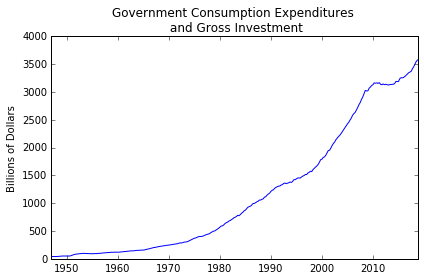

In [3]:
plt.plot(df_gce['Government Consumption Expenditures and Gross Investment'])
plt.title('Government Consumption Expenditures \n and Gross Investment')
plt.ylabel('Billions of Dollars')
plt.tight_layout()

### FRED: Gross Domestic Product (GDP)

In [4]:
gdp = series('gdp')
df_gdp = pd.DataFrame({'Date': gce.dates, 'Gross Domestic Product': gdp.data})
df_gdp.index = pd.to_datetime(df_gdp.Date)
df_gdp = df_gdp[['Gross Domestic Product']]
df_gdp.head()

,Gross Domestic Product
Date,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


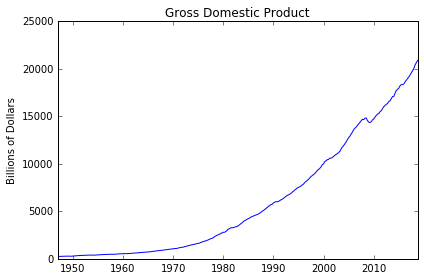

In [5]:
plt.plot(df_gdp['Gross Domestic Product'])
plt.title('Gross Domestic Product')
plt.ylabel('Billions of Dollars')
plt.tight_layout()

## Find the average of the ratio of government consumption to GDP

In [6]:
average_ratio = np.average(df_gce['Government Consumption Expenditures and Gross Investment']/df_gdp['Gross Domestic Product'])
print('Average ratio of government consumption to GDP for the US:', average_ratio)


Average ratio of government consumption to GDP for the US: 0.2059980711717564


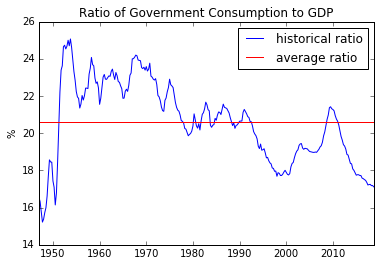

In [7]:
plt.plot(df_gce['Government Consumption Expenditures and Gross Investment']/df_gdp['Gross Domestic Product']*100,label='historical ratio')
plt.axhline(y=average_ratio*100, color='r', linestyle='-',label='average ratio')
plt.title('Ratio of Government Consumption to GDP')
plt.ylabel('%')
plt.legend(loc='best')


## Compute the Steady State Values

In [8]:
# The model's parameters
beta = 0.99
alpha = 0.35
delta = 0.025

# Computer steady state values
a_bar = 1
k_bar = ((1/beta - 1 + delta) / (alpha))**(1/(alpha - 1))
i_bar = delta * k_bar
y_bar = 1 * k_bar**alpha
g_bar = y_bar * average_ratio
t_bar = g_bar
c_bar = y_bar - i_bar - g_bar

print('a_bar:', a_bar)
print('k_bar:', k_bar)
print('y_bar:', y_bar)
print('i_bar:', i_bar)
print('g_bar:', g_bar, '  <=== We are gonna use this value in our model!')
print('t_bar:', t_bar)
print('c_bar:', c_bar)

a_bar: 1
k_bar: 34.3982260521668
y_bar: 3.44974994318268
i_bar: 0.85995565130417
g_bar: 0.7106418343205083   <=== We are gonna use this value in our model!
t_bar: 0.7106418343205083
c_bar: 1.8791524575580019


## Modeling with Linearsolve

In [9]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series
parameters = pd.Series()
parameters['beta'] = beta
parameters['alpha'] = alpha
parameters['delta'] = delta
parameters['rho_a'] = 0.75
parameters['sigma_a_squared'] = 0.006**2
parameters['g_bar'] = g_bar
parameters['rho_g'] = 0.9
parameters['sigma_g_squared'] = 0.015**2

# Print the model's parameters
print(parameters)

beta               0.990000
alpha              0.350000
delta              0.025000
rho_a              0.750000
sigma_a_squared    0.000036
g_bar              0.710642
rho_g              0.900000
sigma_g_squared    0.000225
dtype: float64


In [10]:
# Create variable called 'varNames' that stores the variable names in a list with state variables ordered first
varNames = ['a','k','g','c','t','y','i']

# Create variable called 'shockNames' that stores an exogenous shock name for each state variable.
shockNames = ['e_a', 'e_k', 'e_g']

In [11]:
# Define a function that evaluates the equilibrium conditions of the model solved for zero. PROVIDED
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters. PROVIDED
    p = parameters
    
    # Current variables. PROVIDED
    cur = variables_current
    
    # Forward variables. PROVIDED
    fwd = variables_forward

    # Production function
    production_function = cur.a*cur.k**p.alpha - cur.y

    # Euler equation
    euler_equation = p.beta*(p.alpha*fwd.a*fwd.k**(p.alpha-1)+1-p.delta)/fwd.c - 1/cur.c
    
    # Capital evolution
    capital_evolution = cur.i + (1 - p.delta)*cur.k - fwd.k
    
    # Market clearing
    market_clearing = cur.c + cur.i + cur.g - cur.y
    
    # Government budget constraint
    government_budget_constraint = cur.g - cur.t
    
    # Exogenous tfp
    tfp_process = p.rho_a*np.log(cur.a) - np.log(fwd.a)
    
    # Government consumption evolution
    government_consumption_evolution = (1 - p.rho_g)*np.log(p.g_bar) + p.rho_g*np.log(cur.g) - np.log(fwd.g)
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
        production_function,
        euler_equation,
        capital_evolution,
        market_clearing,
        government_budget_constraint,
        tfp_process,
        government_consumption_evolution
        ])

In [12]:
# Initialize the model into a variable named 'rbc_model'
rbc_model = ls.model(equations = equilibrium_equations,
                 nstates=3,
                 varNames=varNames,
                 shockNames=shockNames,
                 parameters = parameters)

In [13]:
# Compute the steady state numerically using .compute_ss() method of rbc_model
guess = [1,4,0.1,1,0.1,1,1]
rbc_model.compute_ss(guess)

# Print the computed steady state
print(rbc_model.ss)

a     1.000000
k    34.398226
g     0.710642
c     1.879152
t     0.710642
y     3.449750
i     0.859956
dtype: float64


In [14]:
# Find the log-linear approximation around the non-stochastic steady state and solve using .approximate_and_solve() method of rbc_model
rbc_model.approximate_and_solve()
print(rbc_model.solved())

Solution to the log-linear system:

a[t+1] = 0.75·a[t]+e_a[t+1]

k[t+1] = 0.091·a[t]+0.9701·k[t]-0.0146·g[t]+e_k[t+1]

g[t+1] = 0.9·g[t]+e_g[t+1]

  c[t] = 0.1705·a[t]+0.7325·k[t]-0.1104·g[t]

  t[t] = g[t]

  y[t] = a[t]+0.35·k[t]

  i[t] = 3.6389·a[t]-0.1966·k[t]-0.585·g[t]


## Impulse Responses

Compute a 41 period impulse responses of the model's variables to a one percentage point increase in government consumption in period 5.

In [15]:
# Compute impulse responses
rbc_model.impulse(T=41,t0=5,shocks=[0,0,0.01])

# Print the first 10 rows of the computed impulse responses.
rbc_model.irs['e_g'].head(10)

,e_g,a,k,g,c,t,y,i
0,0.00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
1,0.00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
2,0.00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
3,0.00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
4,0.00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
5,0.01,0.000000e+00,0.000000,0.010000,-0.001104,0.010000,-1.492001e-18,-0.005850
6,0.00,-2.347841e-19,-0.000146,0.009000,-0.001101,0.009000,-5.119137e-05,-0.005237
7,0.00,-3.873938e-19,-0.000274,0.008100,-0.001095,0.008100,-9.573224e-05,-0.004685
8,0.00,-4.807205e-19,-0.000384,0.007290,-0.001086,0.007290,-1.343335e-04,-0.004190
9,0.00,-5.316979e-19,-0.000479,0.006561,-0.001075,0.006561,-1.676335e-04,-0.003744


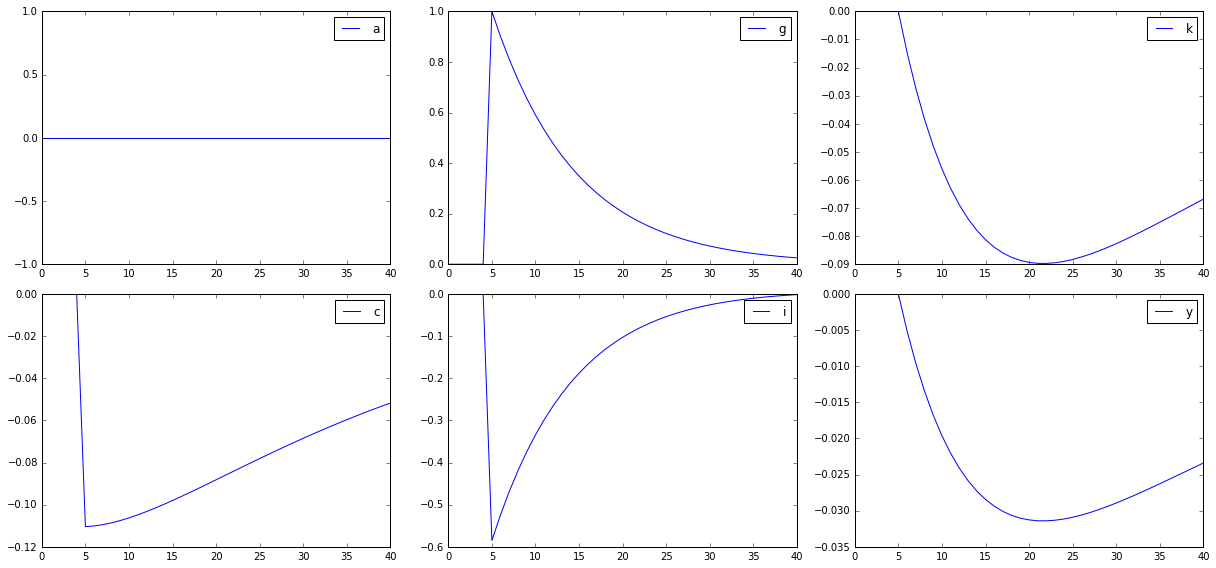

In [16]:
# Create figure.
fig = plt.figure(figsize=(17,8))

# Create upper-left axis.

# tfp response
ax = fig.add_subplot(2,3,1)
ax.plot(rbc_model.irs['e_g']['a']*100)
ax.set_ylim([-1,1])
ax.legend()

# government spending response
ax = fig.add_subplot(2,3,2)
ax.plot(rbc_model.irs['e_g']['g']*100)
ax.legend()

# capital response
ax = fig.add_subplot(2,3,3)
ax.plot(rbc_model.irs['e_g']['k']*100)
ax.legend()

# consumption response
ax = fig.add_subplot(2,3,4)
ax.plot(rbc_model.irs['e_g']['c']*100)
ax.legend()

# investment response
ax = fig.add_subplot(2,3,5)
ax.plot(rbc_model.irs['e_g']['i']*100)
ax.legend()

# gdp response
ax = fig.add_subplot(2,3,6)
ax.plot(rbc_model.irs['e_g']['y']*100)
ax.legend()

plt.tight_layout()